<a href="https://colab.research.google.com/github/Lee-Gunju/AI-paper-code-review-for-personal-project/blob/master/MixUp_augmentation_for_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train = x_train.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))
y_train = tf.one_hot(y_train, 10)

x_test = x_test.astype("float32") / 255.0
x_test = np.reshape(x_test, (-1, 28, 28, 1))
y_test = tf.one_hot(y_test, 10)

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 64
EPOCHS = 10

In [ ]:
# Put aside a few samples to create our validation set
val_samples = 2000
x_val, y_val = x_train[:val_samples], y_train[:val_samples]
new_x_train, new_y_train = x_train[val_samples:], y_train[val_samples:]

In [ ]:
train_ds_one = (tf.data.Dataset.from_tensor_slices((new_x_train, new_y_train)).shuffle(BATCH_SIZE * 100).batch(BATCH_SIZE))
train_ds_two = (tf.data.Dataset.from_tensor_slices((new_x_train, new_y_train)).shuffle(BATCH_SIZE * 100).batch(BATCH_SIZE))

# Because we will be mixing up the images and their corresponding labels, we will be
# combining two shuffled datasets from the same training data.

train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

In [ ]:
train_ds

<ZipDataset shapes: (((None, 28, 28, 1), (None, 10)), ((None, 28, 28, 1), (None, 10))), types: ((tf.float32, tf.float32), (tf.float32, tf.float32))>

In [ ]:
def sample_beta_distribution(size, alpha_0 , alpha_1 ):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=alpha_0)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=alpha_1)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


def mix_up(ds_one, ds_two, alpha=0.2):
    # Unpack two datasets
    images_one, labels_one = ds_one
    images_two, labels_two = ds_two
    batch_size = tf.shape(images_one)[0]

    # Sample lambda and reshape it to do the mixup
    l = sample_beta_distribution(batch_size, alpha, alpha)
    x_l = tf.reshape(l, (batch_size, 1, 1, 1))
    y_l = tf.reshape(l, (batch_size, 1))

    # Perform mixup on both images and labels by combining a pair of images/labels
    # (one from each dataset) into one image/label
    images = images_one * x_l + images_two * (1 - x_l)
    labels = labels_one * y_l + labels_two * (1 - y_l)
    return (images, labels)  


In [ ]:
tf.random.gamma(shape=[3], alpha=0.2)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([1.5409025e-11, 2.6937302e-02, 1.7993152e+00], dtype=float32)>

[0.0, 0.0, 0.0, 0.01711803674697876, 0.0, 0.0, 0.0, 0.0, 0.9828819632530212, 0.0]
[0.0, 0.9999857544898987, 0.0, 0.0, 0.0, 1.424551010131836e-05, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.3781689405441284, 0.0, 0.0, 0.6218310594558716, 0.0]
[0.0, 0.0, 0.4130052924156189, 0.0, 0.0, 0.0, 0.0, 0.5869947075843811, 0.0, 0.0]
[0.0, 0.03403717279434204, 0.965962827205658, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.9704918265342712, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02950817346572876]
[0.0, 0.0, 0.0, 0.6784801483154297, 0.0, 0.0, 0.3215198218822479, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02113446779549122, 0.0, 0.9788655042648315]


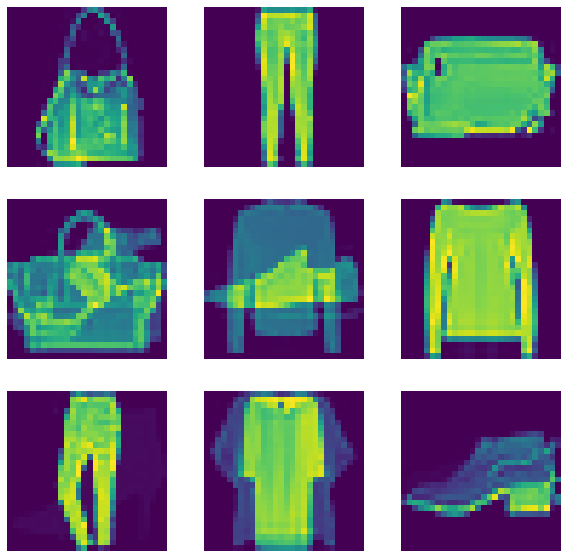

In [ ]:
# First create the new dataset using our `mix_up` utility
train_ds_mu = train_ds.map(
    lambda ds_one, ds_two: mix_up(ds_one, ds_two, alpha=0.2), num_parallel_calls=AUTO
)

# Let's preview 9 samples from the dataset
sample_images, sample_labels = next(iter(train_ds_mu))
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(zip(sample_images[:9], sample_labels[:9])):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().squeeze())
    print(label.numpy().tolist())
    plt.axis("off")

In [ ]:
def get_training_model():
    model = tf.keras.Sequential(
        [
            layers.Conv2D(16, (5, 5), activation="relu", input_shape=(28, 28, 1)),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(32, (5, 5), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Dropout(0.2),
            layers.GlobalAvgPool2D(),
            layers.Dense(128, activation="relu"),
            layers.Dense(10, activation="softmax"),
        ]
    )
    return model

In [ ]:
initial_model = get_training_model()
initial_model.save_weights("initial_weights.h5")

In [ ]:
model = get_training_model()
model.load_weights("initial_weights.h5")
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(train_ds_mu, validation_data=val_ds, epochs=EPOCHS)
_, test_acc = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/10
907/907 [==============================] - 35s 4ms/step - loss: 1.2028 - accuracy: 0.6224 - val_loss: 0.6914 - val_accuracy: 0.7410
Epoch 2/10
907/907 [==============================] - 3s 4ms/step - loss: 0.9587 - accuracy: 0.7188 - val_loss: 0.5903 - val_accuracy: 0.7855
Epoch 3/10
907/907 [==============================] - 4s 4ms/step - loss: 0.8809 - accuracy: 0.7616 - val_loss: 0.5238 - val_accuracy: 0.8215
Epoch 4/10
907/907 [==============================] - 4s 4ms/step - loss: 0.8293 - accuracy: 0.7806 - val_loss: 0.4659 - val_accuracy: 0.8440
Epoch 5/10
907/907 [==============================] - 3s 4ms/step - loss: 0.7943 - accuracy: 0.7965 - val_loss: 0.4634 - val_accuracy: 0.8495
Epoch 6/10
907/907 [==============================] - 3s 4ms/step - loss: 0.7703 - accuracy: 0.8051 - val_loss: 0.4165 - val_accuracy: 0.8565
Epoch 7/10
907/907 [==============================] - 3s 4ms/step - loss: 0.7488 - accuracy: 0.8129 - val_loss: 0.4043 - val_accuracy: 0.8600
Epoch

In [ ]:
model = get_training_model()
model.load_weights("initial_weights.h5")
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
# Notice that we are NOT using the mixed up dataset here
model.fit(train_ds_one, validation_data=val_ds, epochs=EPOCHS)
_, test_acc = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/10
907/907 [==============================] - 4s 3ms/step - loss: 0.8994 - accuracy: 0.6625 - val_loss: 0.6945 - val_accuracy: 0.7405
Epoch 2/10
907/907 [==============================] - 3s 3ms/step - loss: 0.6575 - accuracy: 0.7498 - val_loss: 0.5812 - val_accuracy: 0.7860
Epoch 3/10
907/907 [==============================] - 3s 3ms/step - loss: 0.5823 - accuracy: 0.7824 - val_loss: 0.5446 - val_accuracy: 0.8020
Epoch 4/10
907/907 [==============================] - 3s 3ms/step - loss: 0.5196 - accuracy: 0.8097 - val_loss: 0.4672 - val_accuracy: 0.8395
Epoch 5/10
907/907 [==============================] - 3s 3ms/step - loss: 0.4761 - accuracy: 0.8265 - val_loss: 0.4127 - val_accuracy: 0.8530
Epoch 6/10
907/907 [==============================] - 3s 3ms/step - loss: 0.4415 - accuracy: 0.8385 - val_loss: 0.4035 - val_accuracy: 0.8575
Epoch 7/10
907/907 [==============================] - 3s 3ms/step - loss: 0.4160 - accuracy: 0.8491 - val_loss: 0.3735 - val_accuracy: 0.8655
Epoch 